In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, TFDistilBertForSequenceClassification, BertForSequenceClassification, BertTokenizer
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
df = pd.read_csv('UpdatedResumeDataSet.csv')

In [4]:
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [5]:
df.shape

(962, 2)

In [6]:
df['Category'].value_counts()

Category
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: count, dtype: int64

In [7]:
df.isnull().sum()

Category    0
Resume      0
dtype: int64

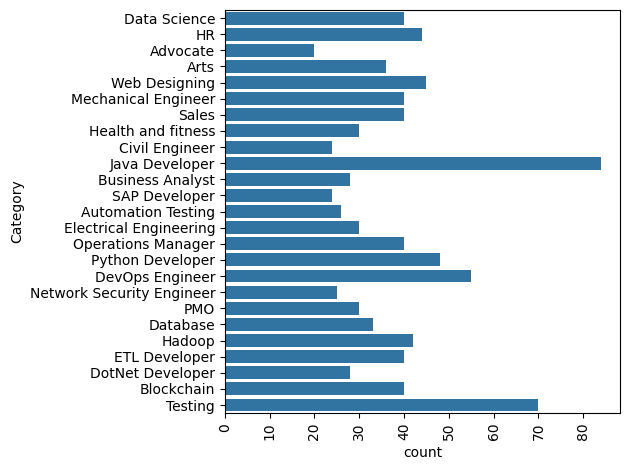

In [8]:
sns.countplot(df.Category)
plt.xticks(rotation=90)
plt.tight_layout();

C:\Users\Atharva Kulkarni\AppData\Local\Temp\ipykernel_24152\3106966570.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.resume_len);


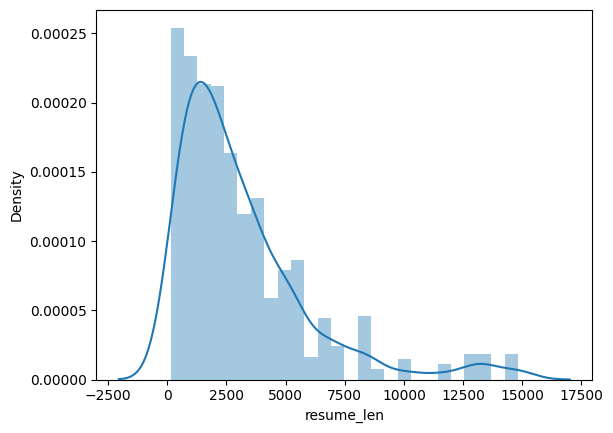

In [9]:
df['resume_len'] = df.Resume.apply(len)
sns.distplot(df.resume_len);

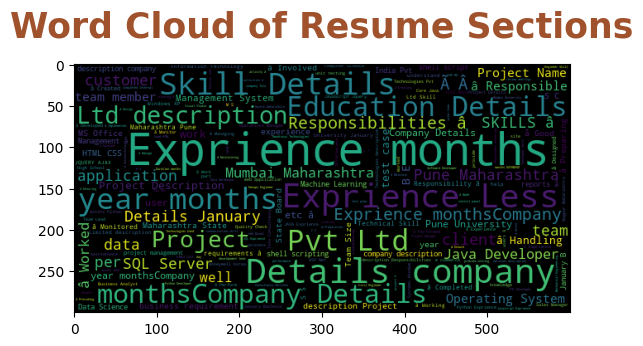

In [10]:
wc = WordCloud(width=600,height=300,random_state=101).generate(' '.join(df.Resume))
plt.title(label='Word Cloud of Resume Sections',pad=20,fontsize=25,fontweight='bold',color='sienna')
plt.imshow(wc);

In [11]:
le = LabelEncoder()
df['Category'] = le.fit_transform(df['Category'])

In [12]:
df.head()

,Category,Resume,resume_len
0,6,Skills * Programming Languages: Python (pandas...,4786
1,6,Education Details \r\nMay 2013 to May 2017 B.E...,1268
2,6,"Areas of Interest Deep Learning, Control Syste...",1871
3,6,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,6995
4,6,"Education Details \r\n MCA YMCAUST, Faridab...",452


In [13]:
num_classes = len(df['Category'].unique())

In [14]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", num_labels=num_classes, ignore_mismatched_sizes=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([25]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([25, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
texts = df['Resume'].tolist()
labels = df['Category'].tolist()

In [16]:
tokenized_texts = [tokenizer.encode(text, add_special_tokens=True, max_length=512, truncation=True) for text in texts]
attention_masks = [[1] * len(text) + [0] * (512 - len(text)) for text in tokenized_texts]

max_len = max(len(token) for token in tokenized_texts)
padded_tokenized_texts = [token + [0] * (max_len - len(token)) for token in tokenized_texts]

In [17]:
print(len(padded_tokenized_texts))
print(len(attention_masks))
o = np.array(padded_tokenized_texts)
a = np.array(attention_masks)
print(o.shape, a.shape)
np.array(labels).shape

962
962
(962, 512) (962, 512)


(962,)

In [18]:
input_ids = torch.tensor(padded_tokenized_texts)
attention_masks = torch.tensor(attention_masks)
labels = torch.tensor(labels)

print(f"input_ids = {input_ids.shape}, attention masks = {attention_masks.shape}, labels = {labels.shape} ")

input_ids = torch.Size([962, 512]), attention masks = torch.Size([962, 512]), labels = torch.Size([962]) 


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [20]:
train_inputs, val_inputs, train_attention_masks, val_attention_masks, train_labels, val_labels = train_test_split(input_ids, attention_masks, labels, test_size=0.2, random_state=42)

In [21]:
train_inputs.shape, val_inputs.shape, train_attention_masks.shape, val_attention_masks.shape, train_labels.shape, val_labels.shape

(torch.Size([769, 512]),
 torch.Size([193, 512]),
 torch.Size([769, 512]),
 torch.Size([193, 512]),
 torch.Size([769]),
 torch.Size([193]))

In [22]:
train_dataset = TensorDataset(train_inputs, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_inputs, val_attention_masks, val_labels)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

In [23]:
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

c:\Users\Atharva Kulkarni\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
texts = df['Resume'].tolist()
labels = df['Category'].tolist()

In [25]:
tokenized_texts = [tokenizer.encode(text, add_special_tokens=True, max_length=512, truncation=True) for text in texts]
attention_masks = [[1] * len(text) + [0] * (512 - len(text)) for text in tokenized_texts]

max_len = max(len(token) for token in tokenized_texts)
padded_tokenized_texts = [token + [0] * (max_len - len(token)) for token in tokenized_texts]

In [26]:
print(len(padded_tokenized_texts))
print(len(attention_masks))
o = np.array(padded_tokenized_texts)
a = np.array(attention_masks)
print(o.shape, a.shape)
np.array(labels).shape

962
962
(962, 512) (962, 512)


(962,)

In [27]:
input_ids = torch.tensor(padded_tokenized_texts)
attention_masks = torch.tensor(attention_masks)
labels = torch.tensor(labels)

print(f"input_ids = {input_ids.shape}, attention masks = {attention_masks.shape}, labels = {labels.shape} ")

input_ids = torch.Size([962, 512]), attention masks = torch.Size([962, 512]), labels = torch.Size([962]) 


In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [29]:
train_inputs, val_inputs, train_attention_masks, val_attention_masks, train_labels, val_labels = train_test_split(input_ids, attention_masks, labels, test_size=0.2, random_state=42)

In [30]:
train_inputs.shape, val_inputs.shape, train_attention_masks.shape, val_attention_masks.shape, train_labels.shape, val_labels.shape

(torch.Size([769, 512]),
 torch.Size([193, 512]),
 torch.Size([769, 512]),
 torch.Size([193, 512]),
 torch.Size([769]),
 torch.Size([193]))

In [31]:
train_dataset = TensorDataset(train_inputs, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_inputs, val_attention_masks, val_labels)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

In [32]:
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

In [35]:
num_epochs = 6

for epoch in range(num_epochs):
    model.train()
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
    for batch in train_loader_tqdm:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        train_loader_tqdm.set_postfix(loss=loss.item()) 

Epoch 6/6: 100%|██████████| 193/193 [00:34<00:00,  5.57it/s, loss=0.0621]


In [36]:
model.eval()

total_val_loss = 0
correct = 0
total = 0

with torch.no_grad():  
    val_loader_tqdm = tqdm(val_loader, desc="Validation")
    lbls = []
    preds = []
    for batch in val_loader_tqdm:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_val_loss += loss.item()
        
        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        lbls.append(labels.detach().cpu().numpy())
        preds.append(predicted.detach().cpu().numpy())
lbls = np.concatenate(lbls)
preds = np.concatenate(preds)
avg_val_loss = total_val_loss / len(val_loader)
accuracy = correct / total# prec
# precision1 = precision_score(lbls, preds)
# recall1 = recall_score(lbls, preds)
# f1_1 = f1_score(lbls, preds)

print(f'Validation Loss: {avg_val_loss}, Accuracy: {accuracy}')
# print(f'Precision: {precision1}, Recall: {recall1}, F1 Score: {f1_1}')

Validation: 100%|██████████| 49/49 [00:02<00:00, 17.98it/s]

Validation Loss: 0.06712329463691127, Accuracy: 0.9948186528497409
